In [186]:
import re
import random
import pandas as pd
import hashlib

In [187]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [188]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Pandas,71.964140,7.196414,15.262863,10
Microsoft Purview,82.376069,1.647521,5.705662,50
"Jane Eyre, Bronte",173.254473,24.750639,69.984806,7
DAX,268.077210,29.786357,106.817263,9
Azure AD Authentication,828.539628,69.044969,140.221321,12
TSQL,834.271199,34.761300,124.335926,24
Azure VM + Developer,1028.928410,30.262600,111.565652,34
Logging in Python,1178.021734,84.144410,605.616810,14
Terraform,1298.271106,72.126173,361.289503,18
Azure Private DNS,1318.662783,69.403304,405.089113,19


# Histogram

sum of ages: ~42991.98


<Axes: >

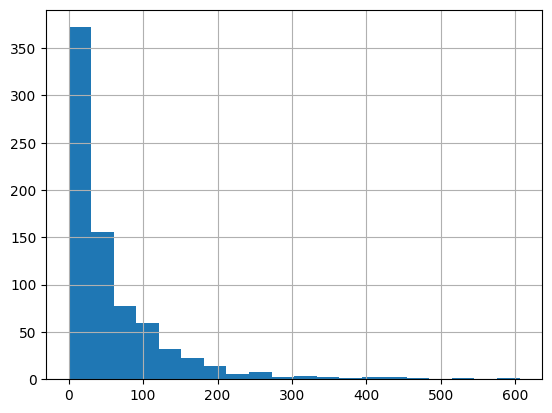

In [189]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~42991.98


<Axes: >

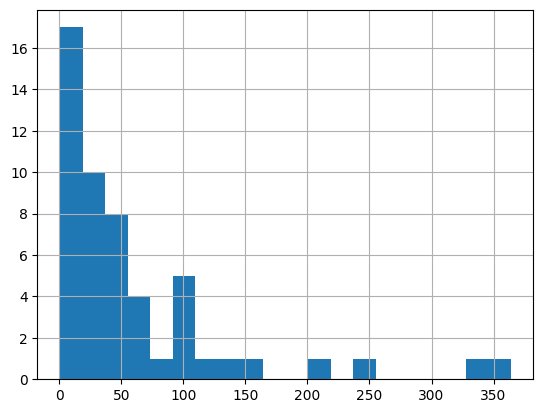

In [190]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [191]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [192]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [193]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [194]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [195]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [196]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [197]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [198]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 762
Total card age: 42991.98


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
14,JavaScript Concepts,Destructuring: Syntax for unpacking values fro...,cf45c67e3fe6d2cc720996005c958996,-450.766075,49.014722,450.766075,-3676.104122,0.402011,0,0
15,JavaScript Concepts,Responsive Design: Designing web applications ...,d84123eee35425e515d3a84a56ac131c,-178.445165,49.014722,450.766075,-3676.104122,0.402011,3,0
16,JavaScript Concepts,"In this example, sayGoodbye is passed as a cal...",2eaa096b522b5bf555c5e2248c28b9b5,-146.209413,49.014722,450.766075,-3676.104122,0.402011,6,0
17,JavaScript Concepts,Netlify: A platform for deploying static sites...,6a183a53d480d7657eee46fde91df5c6,-91.814886,49.014722,450.766075,-3676.104122,0.402011,9,0
18,JavaScript Concepts,Next.js: A React framework for server-side ren...,40c226db8cbea474702cb58287fa1296,-73.631984,49.014722,450.766075,-3676.104122,0.402011,12,0
264,JavaScript Concepts,Jest: A JavaScript testing framework by Facebo...,cf9813cb7427b697fb12369af4bc775b,-71.177920,49.014722,450.766075,-3676.104122,0.402011,15,0
20,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,-62.136370,49.014722,450.766075,-3676.104122,0.402011,18,0
504,JavaScript Concepts,When ... appears on the left-hand side of an a...,e8ab9dfff54f85af4b378fc24a8e1653,-53.223542,49.014722,450.766075,-3676.104122,0.402011,21,0
22,JavaScript Concepts,Prototype-Based Inheritance: JavaScript's inhe...,fab9f5f235a15404e60e2a2184f09e59,-39.975631,49.014722,450.766075,-3676.104122,0.402011,24,0
506,JavaScript Concepts,MDN Web Docs: Comprehensive documentation for ...,c9287adef7e8df34cc143517f912d8d9,-36.398278,49.014722,450.766075,-3676.104122,0.402011,27,0


## Age Mean

In [199]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [200]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [201]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [202]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [203]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
202,Logging in Python,Q: How can you prevent log messages from bubbl...,ba3ed377fb0e6239644735ac2b86a8c6,-605.616810,84.144410,605.616810,-1178.021734,0.282664,0,0
120,PowerShell Modules,Install-Module\n\nDefinition: A cmdlet used to...,abd837efe7378e3e46b08d09a459cae3,-544.232499,86.039950,544.232499,-2753.278384,0.270669,0,0
85,Azure Compute Gallery,VM Deployment from ACG – The process of creati...,9b589f2fb52eedf61e2dc11f57da0d0f,-461.081748,76.442972,461.081748,-3057.718892,0.202516,0,0
182,Azure Functions + PP365,API Gateway Integration\nConnecting Azure Func...,d0210993b8fa777c35753f8d26d9c4a9,-451.270418,81.444022,451.270418,-1710.324470,0.702205,0,0
14,JavaScript Concepts,Destructuring: Syntax for unpacking values fro...,cf45c67e3fe6d2cc720996005c958996,-450.766075,49.014722,450.766075,-3676.104122,0.402011,0,0
189,Azure Private DNS,DNS Proxy\nDefinition: A feature that allows D...,7afb51ca2c17c5d23a40fbb536b4ef56,-405.089113,69.403304,405.089113,-1318.662783,0.056408,0,0
151,FSLogix,Q: How does FSLogix Profile Container enhance ...,6e14a79eafeac794c566a2f5be07a49e,-394.779892,77.606823,394.779892,-2638.631975,0.133844,0,0
241,Azure Developer Associate,Which APIM configuration limits API calls per ...,f3ffbb13a887e8ec77e6ee870d9af2c7,-364.000079,62.011571,364.000079,-3224.601688,0.587747,0,0
196,Terraform,terraform validate:\nA CLI command that checks...,036e232f01695e400da5847ea8babd0d,-361.289503,72.126173,361.289503,-1298.271106,0.580205,0,0
479,Azure Developer Associate,You have an Azure event hub. You need to add p...,e1d05b7e22576ea7494bc54377cf9d46,-342.106047,62.011571,364.000079,-3224.601688,0.587747,1,1


In [204]:
existing_cards.head(10).sum()

head                   JavaScript ConceptsJavaScript ConceptsJavaScri...
body                   Destructuring: Syntax for unpacking values fro...
hash                   cf45c67e3fe6d2cc720996005c958996d84123eee35425...
age                                                         -1203.779264
subject_mean_age                                              490.147216
subject_highest_age                                           4507.66075
subject_age_sum                                             -36761.04122
head_random_roll                                                4.020106
count                                                                135
n_fold                                                                 0
dtype: object

In [205]:
existing_cards['age'].mean()

-56.41991962260713